# Predicting Mobile Phone Prices: Exploratory Data Analysis & Feature Engineering

Filipp Krasovsky, University of San Diego, August 2022

This notebook focuses on identifying the relationships between different features of mobile phones as well as how they inform the price range of a variety of different types of mobile phones. The original context for this dataset can be located <a href='https://www.kaggle.com/datasets/iabhishekofficial/mobile-price-classification'>here.</a>

## Packages

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
import seaborn as sns 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
import sklearn.svm as svm
import utils 
#configure color scheme
plt.style.use('seaborn-white') 
plt.style.use('classic')
sns.set_theme(style="whitegrid", palette="pastel")
import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from xgboost import XGBClassifier

## Global Variables

In [2]:
TRAIN_DATA = '../data/train.csv'
CATEGORICAL_COLS = ['blue','dual_sim','four_g','three_g','touch_screen','wifi','price_range']

## Feature Overview

<table text-align:left>
    <tr><th>Feature</th><th>Info</th></tr>
    <tr><td>battery_power</td><td> Total energy a battery can store in one time measured in mAh</td></tr>
    <tr><td>blue</td><td> Has bluetooth or not</td></tr>
    <tr><td>clock_speed</td><td> speed at which microprocessor executes instructions</td></tr>
    <tr><td>dual_sim</td><td> Has dual sim support or not</td></tr>
    <tr><td>fc</td><td> Front Camera mega pixels</td></tr>
    <tr><td>four_g</td><td> Has 4G or not</td></tr>
    <tr><td>int_memory</td><td> Internal Memory in Gigabytes</td></tr>
    <tr><td>m_dep</td><td> Mobile Depth in cm</td></tr>
    <tr><td>mobile_wt</td><td> Weight of mobile phone</td></tr>
    <tr><td>n_cores</td><td>Number of cores of processor</td></tr>
    <tr><td>pc</td><td>Primary Camera mega pixels</td></tr>
    <tr><td>px_height</td><td>Pixel Resolution Height</td></tr>
    <tr><td>px_width</td><td>Pixel Resolution Width</td></tr>
    <tr><td>ram</td><td>Random Access Memory in Megabytes</td></tr>
    <tr><td>sc_h</td><td>Screen Height of mobile in cm</td></tr>
    <tr><td>sc_w</td><td>Screen Width of mobile in cm</td></tr>
    <tr><td>talk_time</td><td>longest time that a single battery charge will last when you are</td></tr>
    <tr><td>three_g</td><td>Has 3G or not</td></tr>
    <tr><td>touch_screen</td><td>Has touch screen or not</td></tr>
    <tr><td>wifi</td><td>Has wifi or not</td></tr>
    <tr><td><b>price_range (target)</b></td><td>Class of price, 1 = lowest</td></tr>
</table>

## Data Ingestion

In [3]:
df = pd.read_csv(TRAIN_DATA)
df.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,...,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,1208,1212,1411,8,2,15,1,1,0,1


In [4]:
print(df.shape)

(2000, 21)


because we're working with a relatively small dataset, we might have to be cautious about feature engineering and may have to rely on bagging/boosting, as well cross validation.

## Feature Analysis and Interpretation
### Heatmap of Quantitative Variables
There is, intuitively, a strong correlation between the number of megapixels between the front and rear cameras, as well as pixel resolution height and width, and screen height and width. Otherwise, we benefit from having relatively uncorrelated data.

Text(0.5, 1.0, 'Correlation of Variables for Mobile Sales Data')

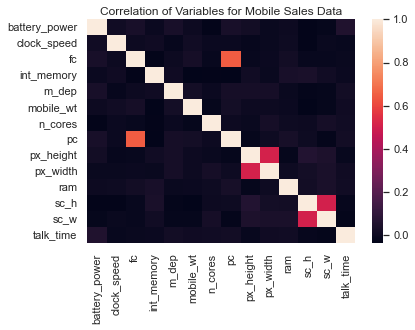

In [4]:
q = df.drop(columns = CATEGORICAL_COLS)
sns.heatmap(q.corr());
plt.title("Correlation of Variables for Mobile Sales Data")

### Battery Power

Text(0.5, 0, 'Killowat-Hours')

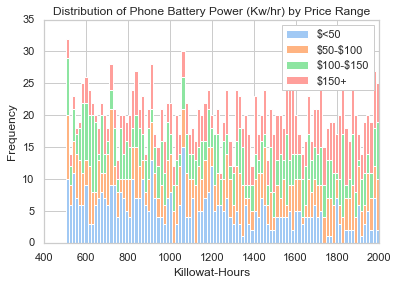

In [15]:
df.pivot(columns="price_range", values="battery_power").plot.hist(bins=100,stacked=True)
plt.title("Distribution of Phone Battery Power (Kw/hr) by Price Range")
plt.legend(['$<50','\$50-\$100','\$100-\$150','$150+'])
plt.xlabel('Killowat-Hours')

### Ram

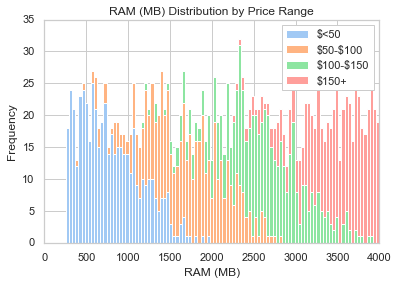

In [16]:
df.pivot(columns="price_range", values="ram").plot.hist(bins=100,stacked=True)
plt.title("RAM (MB) Distribution by Price Range")
plt.xlabel("RAM (MB)")
plt.legend(['$<50','\$50-\$100','\$100-\$150','$150+'])
plt.show()

### Feature Importance

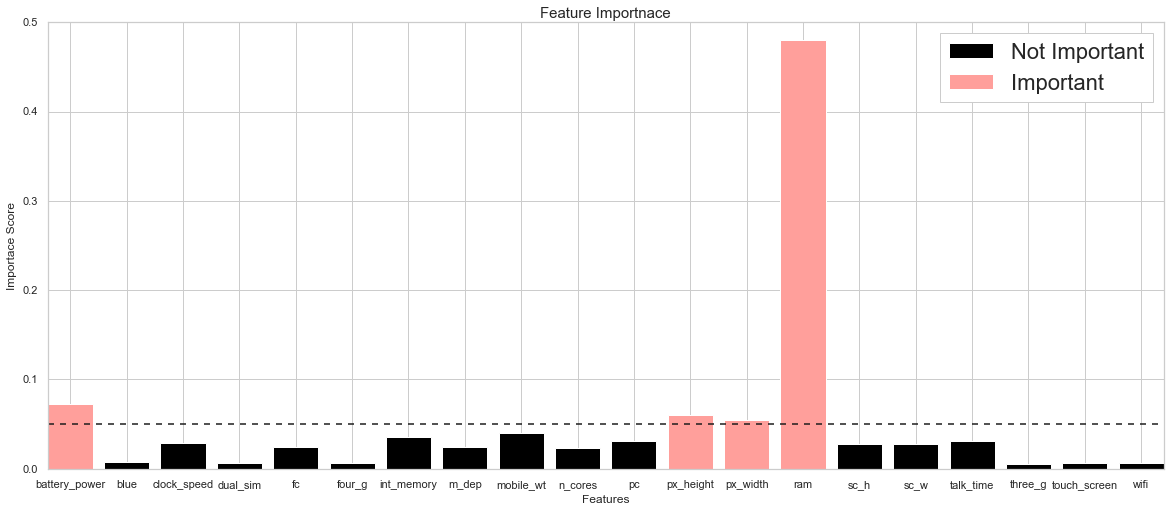

In [8]:
utils.getFeatureImportance(df,'price_range')

Text(0, 0.5, 'battery power')

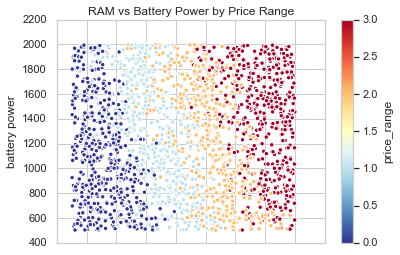

In [17]:
df.plot.scatter(x = 'ram', y= 'battery_power', c='price_range',colormap='RdYlBu_r')
plt.xlabel('ram')
plt.title("RAM vs Battery Power by Price Range")
plt.ylabel('battery power')

### Implementing an XGBOOST Classifier

In [83]:
from sklearn.model_selection import train_test_split
x = df.drop(columns=['price_range'])
y = df['price_range']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

In [73]:
model = XGBClassifier(max_depth=3)
model.fit(x_train,y_train)
y_pred = model.predict(x_test)
rf_cm = accuracy_score(y_test,y_pred)
rf_cm

0.9375

### Naive Bayes

In [84]:
from sklearn.naive_bayes import GaussianNB

#x = df[['ram','battery_power']]
# x = df.drop(columns=['price_range'])
# y = df['price_range']
# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

gnb = GaussianNB()
gnb.fit(x_train,y_train)
y_pred = gnb.predict(x_test)
accuracy_score(y_test,y_pred)

0.792

### Logistic Regression
Scale values to prevent non-convergence.

In [36]:
LOG_REG_FEATS = ['ram','battery_power','px_height','px_width']
from sklearn.linear_model import LogisticRegression

In [81]:
#‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’
x = df[LOG_REG_FEATS]

for f in LOG_REG_FEATS:
    mu = x[f].mean()
    sigma = x[f].std()
    
    x[f] = (x[f]-mu)/sigma

y = df['price_range']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

In [46]:
glm = LogisticRegression()
glm.fit(x_train,y_train)
y_pred = glm.predict(x_test)
print(accuracy_score(y_test,y_pred))

0.9725
